### Part 1: Characterizing Features of Data

In [34]:
# set up
# Please install the following packages before running the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from scipy.stats import chi2
from scipy.stats import f as ft
import pymc as pm
import arviz as az
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
import rpy2.robjects as ro



In [35]:
# Load data
df = pd.read_csv('../Data/data_em.csv')

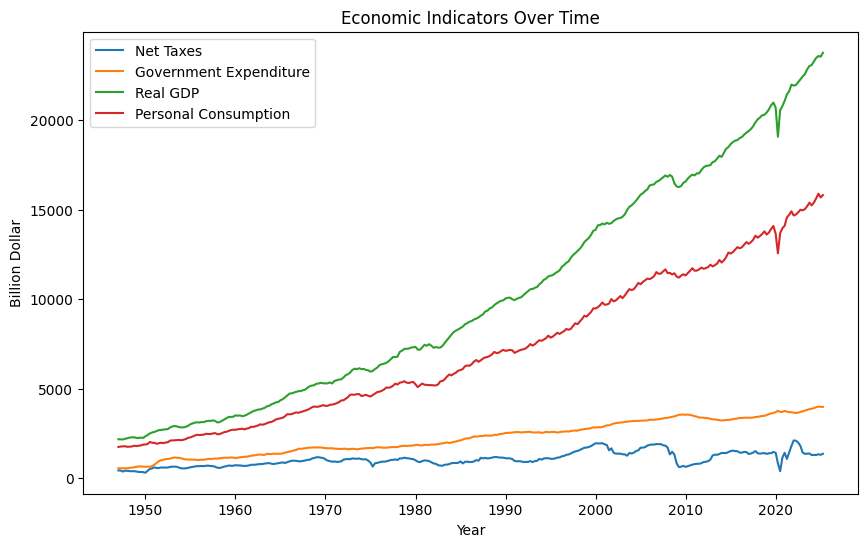

In [36]:
# plot the data with quarter-level detail but decade x-axis labels
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Net_Taxes'], label='Net Taxes')
plt.plot(df['Date'], df['Gov_Expenditure'], label='Government Expenditure')
plt.plot(df['Date'], df['RGDP'], label='Real GDP')
plt.plot(df['Date'], df['Per_Consumption'], label='Personal Consumption')

decade_years = range(1950, df['Year'].max() + 10, 10)
decade_positions = []
decade_labels = []

for year in decade_years:
    year_indices = df[df['Year'] == year].index
    if len(year_indices) > 0:
        decade_positions.append(year_indices[0])
        decade_labels.append(str(year))

plt.xticks(decade_positions, decade_labels)
plt.legend()
plt.title('Economic Indicators Over Time')
plt.xlabel('Year')
plt.ylabel('Billion Dollar')
plt.savefig('../Result/level_plot.png')
plt.show()

In [37]:
# Turn to growth rate

# df['Net_Taxes_gr'] = 100*np.log(df['Net_Taxes'])
# df['Net_Taxes_gr'] = df['Net_Taxes_gr'].diff()
# df['Gov_Expenditure_gr'] = 100*np.log(df['Gov_Expenditure'])
# df['Gov_Expenditure_gr'] = df['Gov_Expenditure_gr'].diff()
# df['RGDP_gr'] = 100*np.log(df['RGDP'])
# df['RGDP_gr'] = df['RGDP_gr'].diff()
# df['Per_Consumption_gr'] = 100*np.log(df['Per_Consumption'])
# df['Per_Consumption_gr'] = df['Per_Consumption_gr'].diff()

df['Net_Taxes_gr'] = 100 * df['Net_Taxes'].pct_change()

df['Gov_Expenditure_gr'] = 100 * df['Gov_Expenditure'].pct_change()

df['RGDP_gr'] = 100 * df['RGDP'].pct_change()

df['Per_Consumption_gr'] = 100 * df['Per_Consumption'].pct_change()

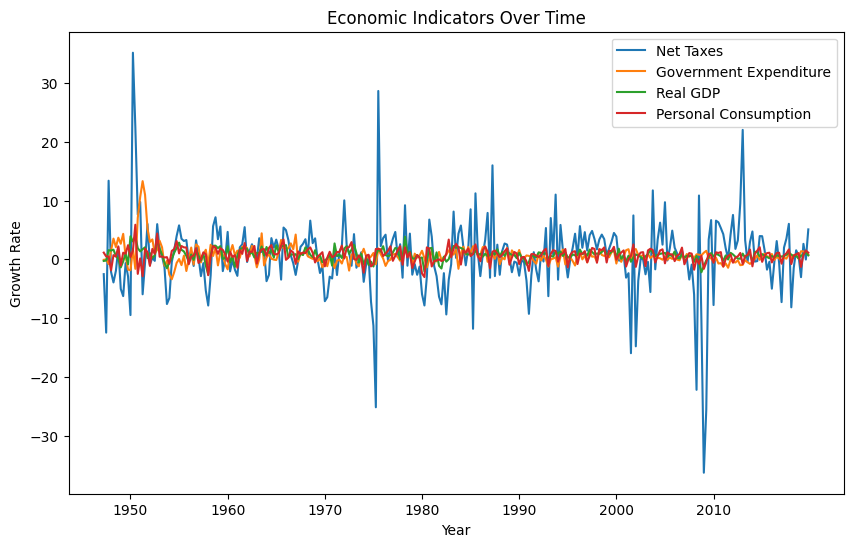

In [38]:
# truncate the data to 2019 for readibility of plots
dfx=df.loc[df['Year']<=2019]
plt.figure(figsize=(10, 6))
plt.plot(dfx['Date'], dfx['Net_Taxes_gr'], label='Net Taxes')
plt.plot(dfx['Date'], dfx['Gov_Expenditure_gr'], label='Government Expenditure')
plt.plot(dfx['Date'], dfx['RGDP_gr'], label='Real GDP')
plt.plot(dfx['Date'], dfx['Per_Consumption_gr'], label='Personal Consumption')

decade_years = range(1950, dfx['Year'].max() + 10, 10)
decade_positions = []
decade_labels = []

for year in decade_years:
    year_indices = dfx[dfx['Year'] == year].index
    if len(year_indices) > 0:
        decade_positions.append(year_indices[0])
        decade_labels.append(str(year))

plt.xticks(decade_positions, decade_labels)
plt.legend()
plt.title('Economic Indicators Over Time')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.savefig('../Result/gr_all.png')
plt.show()

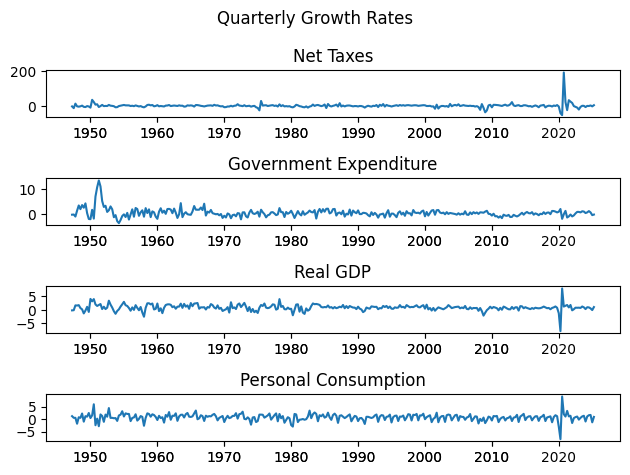

In [39]:
# plot of growth rate in a different way: plotting each variable in a separate
# subplot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.suptitle('Quarterly Growth Rates')

for year in decade_years:
    year_indices = df[df['Year'] == year].index
    if len(year_indices) > 0:
        decade_positions.append(year_indices[0])
        decade_labels.append(str(year))

ax1.plot(df['Date'], df['Net_Taxes_gr'])
ax1.set_title('Net Taxes')
ax1.set_xticks(decade_positions)
ax1.set_xticklabels(decade_labels)

ax2.plot(df['Date'], df['Gov_Expenditure_gr'])
ax2.set_title('Government Expenditure')
ax2.set_xticks(decade_positions)
ax2.set_xticklabels(decade_labels)

ax3.plot(df['Date'], df['RGDP_gr'])
ax3.set_title('Real GDP')
ax3.set_xticks(decade_positions)
ax3.set_xticklabels(decade_labels)

ax4.plot(df['Date'], df['Per_Consumption_gr'])
ax4.set_title('Personal Consumption')
ax4.set_xticks(decade_positions)
ax4.set_xticklabels(decade_labels)

plt.tight_layout()
plt.savefig('../Result/gr.png')
plt.show()

In [40]:
# Keep the main variables for later analysis
dt = df[['RGDP_gr', 'Per_Consumption_gr', 'Gov_Expenditure_gr', 'Net_Taxes_gr']].dropna()
dt.columns = ['RGDP', 'Per_Cons', 'Gov_Exp', 'Taxes']

### -------------------- Reduced-Form VAR ----------------------

In [41]:
# VAR: Just Vector OLS on variables and their lags
# Rule of thumb: at least as large as the number of observation in a year
# Use BIC to select the lag length

# Try m = 4
model = VAR(dt)
res4 = model.fit(4)
res5 = model.fit(5)
res6 = model.fit(6)
print(res4.bic, res5.bic, res6.bic)

5.986138919138332 6.17915058673384 6.426105066120382


/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [42]:
# Based on BIC, m = 4
res4.summary()

/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: divide by zero encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: overflow encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: invalid value encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Dec, 2025
Time:                     16:11:20
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    5.98614
Nobs:                     309.000    HQIC:                   5.49303
Log likelihood:          -2483.73    FPE:                    175.039
AIC:                      5.16456    Det(Omega_mle):         141.285
--------------------------------------------------------------------
Results for equation RGDP
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.553227         0.113953            4.855           0.000
L1.RGDP            -0.000100         0.077111           -0.001           0.999
L1.Per_Cons         0.148645         0.063519            2.340       

/Users/jie/Library/Python/3.12/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/jie/Library/Python/3.12/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/jie/Library/Python/3.12/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1548: RuntimeWarning: divide by zero encountered in matmul
  return 2 * D_Kinv @ sigxsig @ D_Kinv.T
/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1548: RuntimeWarning: overflow encountered in matmul
  return 2 * D_Kinv @ sigxsig @ D_Kinv.T
/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1548: RuntimeWarning:

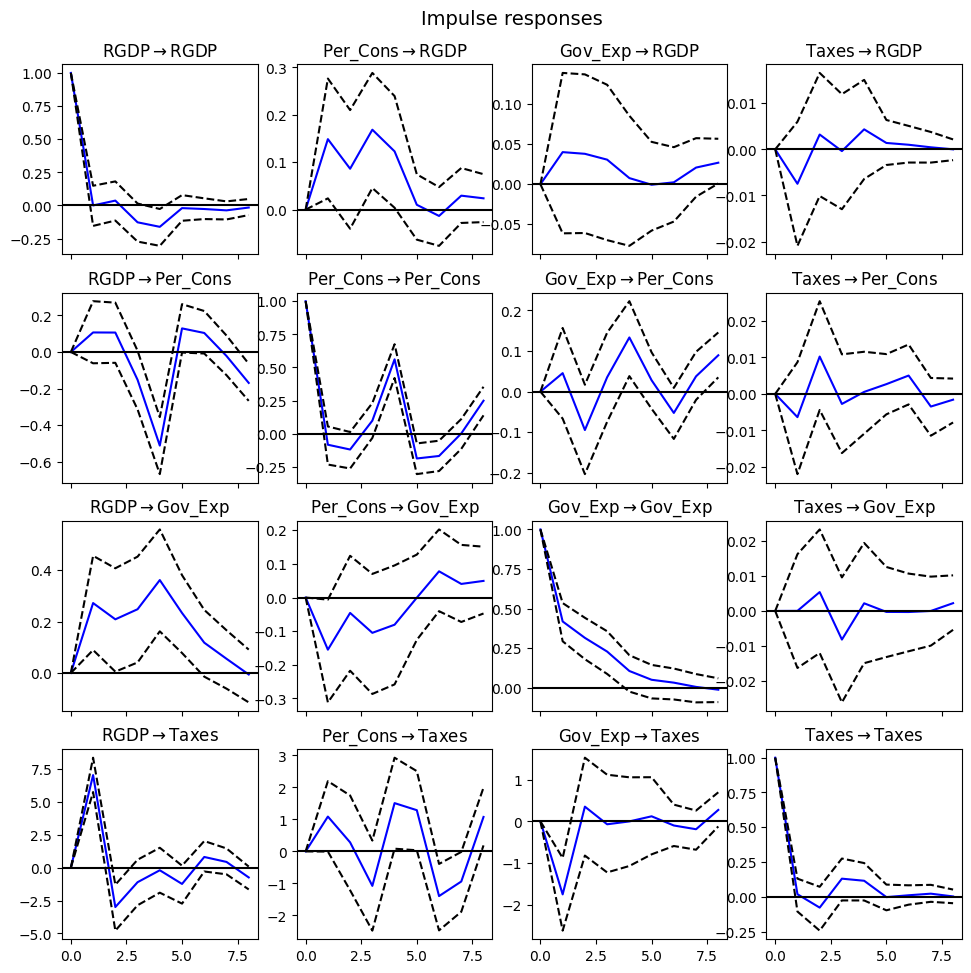

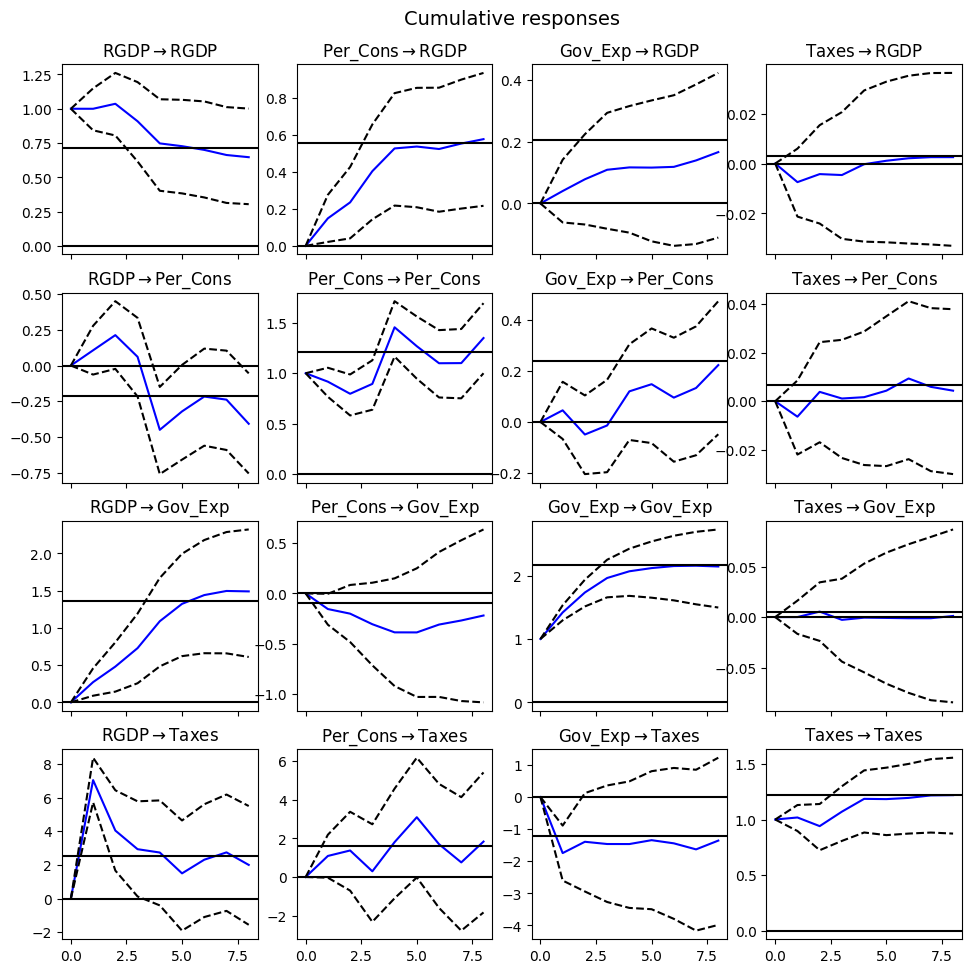

In [43]:
# Reduced-form impulse response function
# Not sure about the prior, choose MC for Bias-corrected bootstrap
irf = res4.irf(8)
irf.plot(orth=False, stderr_type='mc',signif=0.05,repl=10000)
plt.savefig('../Result/irf_var.png')
plt.show()
irf.plot_cum_effects(orth=False, stderr_type='mc',signif=0.05,repl=10000)
plt.savefig('../Result/irf_cum_var.png')
plt.show()


In [44]:
# Impulse response function with bias-corrected bootstrap
B = 1000 # number of bootstrap samples
T = dt.shape[0] # number of observations
k = res4.coefs.shape[0] # number of variables
p = res4.k_ar # number of lags
resid = res4.resid.values 
coefs = res4.coefs 


Y = dt.values # convert data to matrix T by k
Y_lagged = [] # lags of Y
for lag in range(1, p+1):
    Y_lagged.append(Y[p-lag:-lag])
Y_lag = np.hstack(Y_lagged) 
Y_curr = Y[p:] 

B1 = 500 # number of bootstrap samples for bias estimation
coef_flat = coefs.transpose(2,0,1).reshape(p*k, k).T  

bias_estimates = []
for b in range(B1):
    # Generate bootstrap residuals
    idx = np.random.choice(T-p, size=T-p, replace=True)
    resid_boot = resid[idx]
    
    # Generate artificial data using estimated parameters as true values
    Y_boot = np.zeros_like(Y)
    Y_boot[:p] = Y[:p]  # Initialize with actual data
    
    for t in range(p, T):
        Y_lag_flat = Y_boot[t-p:t].flatten(order='F')  # Stack lags
        Y_boot[t] = coef_flat @ Y_lag_flat + resid_boot[t-p]
    
    # Fit VAR on generated data
    dt_boot = pd.DataFrame(Y_boot, columns=dt.columns)
    model_boot = VAR(dt_boot)
    res_boot = model_boot.fit(p)
    
    # Calculate bias: estimate - "true" value
    bias = res_boot.coefs - coefs
    bias_estimates.append(bias)

# Average bias
avg_bias = np.mean(np.array(bias_estimates), axis=0)

coefs_corrected = coefs + avg_bias

irfs_boot = []
irf_horizon = irf.irfs.shape[0]


for b in range(B):
    # Generate bootstrap data using bias-corrected parameters as true values
    idx = np.random.choice(T-p, size=T-p, replace=True)
    resid_boot = resid[idx]
    
    Y_boot = np.zeros_like(Y)
    Y_boot[:p] = Y[:p]
    
    # Reshape corrected coefficients
    coef_corr_flat = coefs_corrected.transpose(2,0,1).reshape(p*k, k).T
    
    for t in range(p, T):
        Y_lag_flat = Y_boot[t-p:t].flatten(order='F')
        Y_boot[t] = coef_corr_flat @ Y_lag_flat + resid_boot[t-p]

   # Fit VAR and compute IRFs
    dt_boot = pd.DataFrame(Y_boot, columns=dt.columns)
    model_boot = VAR(dt_boot)
    res_boot = model_boot.fit(p)
    irf_boot = res_boot.irf(irf_horizon-1)
    irfs_boot.append(irf_boot.irfs)

irfs_boot = np.array(irfs_boot)


/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: divide by zero encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: overflow encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: invalid value encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Users/jie/Library/Python/3.12/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/jie/Library/Python/3.12/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/jie/Library/Python/3.12/lib/python/site-p

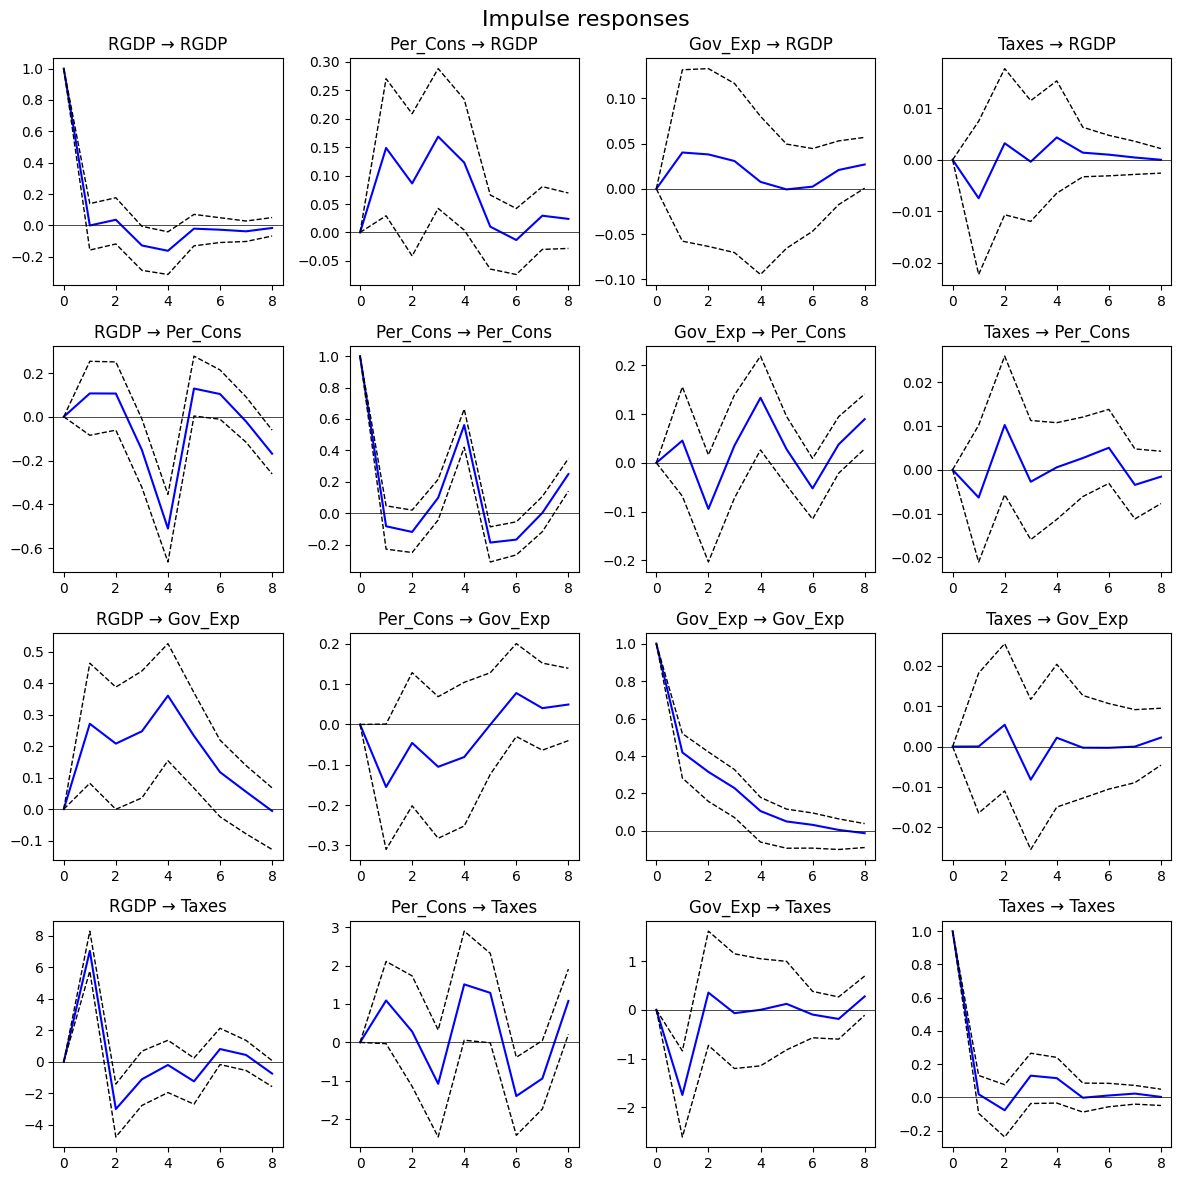

In [45]:
# Plot bias-corrected bootstrap IRFs
lower = np.percentile(irfs_boot, 2.5, axis=0)
upper = np.percentile(irfs_boot, 97.5, axis=0)

var_names = ['RGDP', 'Per_Cons', 'Gov_Exp', 'Taxes']
n_vars = len(var_names)

fig, axes = plt.subplots(n_vars, n_vars, figsize=(12, 12))
fig.suptitle('Impulse responses', fontsize=16)

for i in range(n_vars):
    for j in range(n_vars):
        ax = axes[i, j]
        ax.plot(irf.irfs[:, i, j], 'b-', linewidth=1.5)
        ax.plot(lower[:, i, j], 'k--', linewidth=1)
        ax.plot(upper[:, i, j], 'k--', linewidth=1)
        ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        ax.set_title(f'{var_names[j]} → {var_names[i]}')

plt.tight_layout()
plt.savefig('../Result/irf_boot.png')
plt.show()

### ---------------------- Bayesian Extension ----------------------

In [46]:
ro.r('library(bvhar)')

# Convert pandas DataFrame to R data frame using context manager
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri

with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(dt)

# Assign to R global environment
ro.globalenv['r_df'] = r_df

# set_bvar: 
# sigma: standard deviation of the data
# lambda: shrinkage parameter
# delta: Persistent: vector of zeros (White noise)
# eps: small number to avoid division by zero

ro.r('''
fit <- bvar_minnesota(y = r_df, p = 4, 
bayes_spec = set_bvar(sigma = apply(r_df, 2, sd), lambda = 0.2, delta = rep(0,4), eps = 1e-4), 
include_mean = TRUE)
''')
ro.r('print(fit)')

OpenMP not available in this machine.


R callback write-console: 
  


Call:
bvar_minnesota(y = r_df, p = 4, bayes_spec = set_bvar(sigma = apply(r_df, 
    2, sd), lambda = 0.2, delta = rep(0, 4), eps = 1e-04), include_mean = TRUE)

BVAR(4) with Minnesota Prior

A ~ Matrix Normal (Mean, Precision, Scale = Sigma)
Matrix Normal Mean for A1 part:
           RGDP_1  Per_Cons_1  Gov_Exp_1     Taxes_1
RGDP      0.06224     0.07567   0.008749  -0.0034976
Per_Cons  0.16696    -0.12647  -0.001361  -0.0043678
Gov_Exp   0.19988    -0.10530   0.426334   0.0009192
Taxes     6.05431     1.52769  -1.368350  -0.0195292


Matrix Normal Mean for A2 part:
            RGDP_2  Per_Cons_2  Gov_Exp_2     Taxes_2
RGDP       0.07339     0.03471  -0.003258   0.0021735
Per_Cons   0.10023    -0.13726  -0.052925   0.0046243
Gov_Exp    0.07200     0.01979   0.113087   0.0008312
Taxes     -1.87777    -0.75201   0.417542  -0.0763200


Matrix Normal Mean for A3 part:
            RGDP_3  Per_Cons_3  Gov_Exp_3     Taxes_3
RGDP      -0.04575     0.04828  -0.003995  -0.0008604
Per_Cons  -0.0

In [47]:
fit_sd = ro.r('fit$.sd')

In [48]:
## Save the output
VAR_output = str(res4.summary())
BVAR_output = ro.r('capture.output(print(fit))')
with open('../Result/VAR_summary.txt', 'w') as f:
    f.write(VAR_output)
with open('../Result/BVAR_summary.txt', 'w') as f:
    f.write('\n'.join(BVAR_output))

### -------------- Stationarity and Structural Break --------------

In [49]:
# Test for stationarity - growth rate
# Unit root test
for var in dt.columns:
    adf_result = adfuller(dt[var])
    test_stat = adf_result[0]
    p_value = adf_result[1]
    print(f"{var}: t_stats = {test_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"  => {var} is stationary (reject H0)")
    else:
        print(f"  => {var} is non-stationary (fail to reject H0)")



RGDP: t_stats = -15.4072, p-value = 0.0000
  => RGDP is stationary (reject H0)
Per_Cons: t_stats = -3.8491, p-value = 0.0024
  => Per_Cons is stationary (reject H0)
Gov_Exp: t_stats = -4.8235, p-value = 0.0000
  => Gov_Exp is stationary (reject H0)
Taxes: t_stats = -10.4448, p-value = 0.0000
  => Taxes is stationary (reject H0)


In [50]:
# Test for structural break 
# No idea about the break point (Covid?)
# covid: 2020Q2 
from numpy.linalg import det


covid_date = "2020_Q2"
before_covid = df.loc[df['Date'] < covid_date, 
                       ['Net_Taxes_gr', 'Gov_Expenditure_gr', 'RGDP_gr', 'Per_Consumption_gr']].dropna()

after_covid = df.loc[df['Date'] >= covid_date, 
                      ['Net_Taxes_gr', 'Gov_Expenditure_gr', 'RGDP_gr', 'Per_Consumption_gr']].dropna()
T1 = before_covid.shape[0]
# Estimate VAR on before covid
VAR_before = VAR(before_covid)
res_before = VAR_before.fit(4)
sigma_before = res_before.resid.T@res_before.resid/T1

T2 = after_covid.shape[0]
# Estimate VAR on after covid
VAR_after = VAR(after_covid)
res_after = VAR_after.fit(4)
sigma_after = res_after.resid.T@res_after.resid/T2

T = res4.resid.shape[0]
sigma_full = res4.resid.T@res4.resid/T

# Test for structural break
test_stat = T * np.log(det(sigma_full))-T1 * np.log(det(sigma_before))-T2 * np.log(det(sigma_after))

# test_stat is approximately chi-square distributed with (k(1+kp)+k(k+1)/2) degrees of freedom
deg_free = (k*(1+k*p)+k*(k+1)/2)
p_value = 1-chi2.cdf(test_stat, deg_free)
print(f"Test statistic: {test_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Test statistic: 5241.5361
P-value: 0.0000


/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/jie/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [51]:
# RGDP_gr = net_taxes_gr + gov_expenditure_gr + per_consumption_gr
# Test if coefficient for net_taxes_gr is the same between before and after covid

y = "RGDP_gr"
X_cols = ["Net_Taxes_gr", "Gov_Expenditure_gr", "Per_Consumption_gr"]

# Before covid
X_before = sm.add_constant(before_covid[X_cols])
y_before = before_covid[y]
before_ols = sm.OLS(y_before, X_before).fit()
SSR_before = before_ols.resid.T@before_ols.resid

# After covid
X_after = sm.add_constant(after_covid[X_cols])
y_after = after_covid[y]
after_ols = sm.OLS(y_after, X_after).fit()
SSR_after = after_ols.resid.T@after_ols.resid

# Test statistic: approximate F(1, T-2-2*1)
test_stat = (T-2-2*1)*(SSR_before-SSR_after)/(1*SSR_after)
p_value = 1-ft.cdf(test_stat, 1, T-2-2*1)
print(f"Test statistic: {test_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Test statistic: 6233.1165
P-value: 0.0000
